<a href="https://colab.research.google.com/github/alexanderwhatley/TCR-Pathogen-Identification/blob/master/train_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Requires install of pepnet (https://github.com/openvax/pepnet) and MHCFlurry (https://github.com/openvax/mhcflurry). 

In [1]:
!pip install pepnet
!pip install mhcflurry
!pip install biopython

    100% |████████████████████████████████| 81kB 4.4MB/s 
  Running setup.py bdist_wheel for pepnet ... - \ done
  Stored in directory: /root/.cache/pip/wheels/32/1b/7c/1832578608902eb544bccad6514ffe5d15d270df4f9d3cd37d
  Running setup.py bdist_wheel for serializable ... - \ done
  Stored in directory: /root/.cache/pip/wheels/57/ea/39/77dbaca2061ba8e87ad8b83ead5814467fb0d748d1d9f1d77d
  Running setup.py bdist_wheel for typechecks ... - \ done
  Stored in directory: /root/.cache/pip/wheels/27/ad/82/4a9bbc88f1d31bb1a0c053e29efafc02f56e2ed1598f5639b2
  Running setup.py bdist_wheel for simplejson ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/5d/1a/1e/0350bb3df3e74215cd91325344cc86c2c691f5306eb4d22c77
Successfully built pepnet serializable typechecks simplejson
    100% |████████████████████████████████| 61kB 2.2MB/s 
  Running setup.py bdist_wheel for mhcflurry ... - \ done
  Stored in directory: /root/.cache/pip/wheels/b6/ca/75/5c6695e072d67c8e6e344ad

In [0]:
import io
from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
auth.authenticate_user()

def download_file(name, file_id):
    drive_service = build('drive', 'v3')
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
      status, done = downloader.next_chunk()
      print('Percent downloaded', int(100 * status.progress()))
    downloaded.seek(0)
    f = open(name, 'wb')
    f.write(downloaded.read())
    f.close()

In [3]:
download_file('vdjdb_data.tsv', '1Vzpw6hprVQjRbmM6wZXMeY3HQW-OuXlY')
download_file('uniprot-filtered-reviewed-human.fasta', '1lRALwQInvWtdUpVsgSiZnEhuTPbZJX6B')
download_file('McPAS-TCR.csv', '19eV_s7h3ueFDl_FeE5D8fycd9oHhiBo-')

Percent downloaded 100
Percent downloaded 100
Percent downloaded 100


## Read in Positive Binding Datasets 

In [8]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from pepnet.encoder import Encoder

vdjdb_data = pd.read_csv('vdjdb_data.tsv', sep='\t')
mcpas_data = pd.read_csv('McPAS-TCR.csv', encoding = "ISO-8859-1")
# take only human data for now 
mcpas_data = mcpas_data[(mcpas_data['Species'] == 'Human') & 
                        pd.notnull(mcpas_data['MHC']) & 
                        pd.notnull(mcpas_data['CDR3.beta.aa']) & 
                        pd.notnull(mcpas_data['Epitope.peptide'])] 

mhc_i_regex = re.compile('HLA-.:*')
vdjdb_data = vdjdb_data[['CDR3', 'MHC A', 'MHC class', 'Epitope']].rename(columns={'MHC A': 'MHC'})
mcpas_data = mcpas_data[['CDR3.beta.aa', 'Epitope.peptide', 'MHC']].rename(
    columns={'CDR3.beta.aa' : 'CDR3', 'Epitope.peptide': 'Epitope'})
mcpas_data['MHC class'] = mcpas_data['MHC'].apply(lambda x: 'MHCI' if mhc_i_regex.match(x) else 'MHCII')
mcpas_data['CDR3'] = mcpas_data['CDR3'].str.upper()
mcpas_data['Epitope'] = mcpas_data['Epitope'].str.upper()

all_data = pd.concat([vdjdb_data, mcpas_data], ignore_index=True)
all_data = all_data[all_data['MHC class'] == 'MHCI']
all_data.drop(['MHC class'], axis=1, inplace=True)
all_data.drop_duplicates(inplace=True)
cdr3_length = all_data['CDR3'].apply(len)
peptide_length = all_data['Epitope'].apply(len)

print('Max CDR3 length = {}, Max peptide length = {}'.format(cdr3_length.max(), peptide_length.max()))
print('Number of examples: {}'.format(all_data.shape[0]))

lengths_total = []
for length in [8, 9, 10, 11]:
  lengths_total.append(all_data[all_data['Epitope'].str.len() == length].shape[0])
lengths_total = np.array(lengths_total)
lengths_prob = lengths_total / np.sum(lengths_total)

Max CDR3 length = 38, Max peptide length = 20
Number of examples: 21446


Text(0.5,1,'CDR3 Lengths')

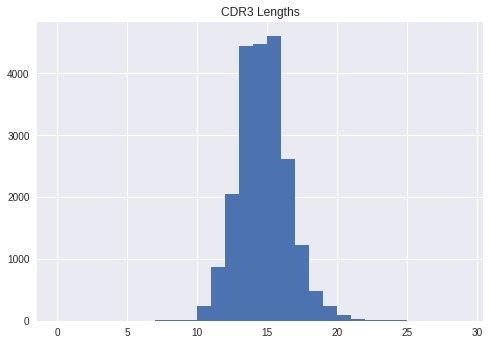

In [41]:
plt.hist(cdr3_length, bins=np.arange(0, 30))
plt.title('CDR3 Lengths')

Text(0.5,1,'Peptide Lengths')

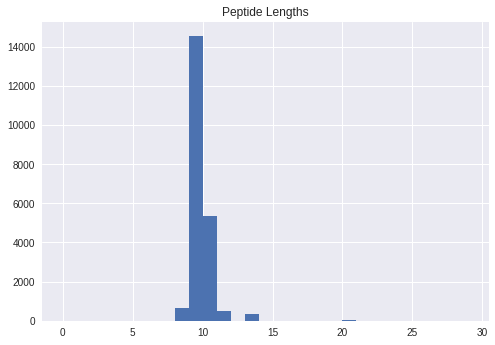

In [42]:
plt.hist(peptide_length, bins=np.arange(0, 30))
plt.title('Peptide Lengths')

In [0]:
encoder = Encoder()
# for now only keep data points with CDR3 length <= 20 and epitope length <= 11
all_data = all_data[(all_data['CDR3'].str.len() <= 20) & 
                    (all_data['Epitope'].str.len() <= 11)]
cdr3_encoded = encoder.encode_onehot(all_data['CDR3'].values, max_peptide_length=20)
cdr3_encoded = cdr3_encoded.reshape((len(cdr3_encoded), -1))
epitope_encoded = encoder.encode_onehot(all_data['Epitope'].values, max_peptide_length=11)
epitope_encoded = epitope_encoded.reshape((len(epitope_encoded), -1))
combined_positive_peptides = np.concatenate((cdr3_encoded, epitope_encoded), axis=1)

## Train Model that determines whether the TCR strand attaches to Epitope

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

def get_accuracy(combined_positive_peptides, combined_negative_peptides):
  experiment_data = np.concatenate((combined_positive_peptides, 
                                    combined_negative_peptides), axis=0)
  experiment_labels = np.concatenate((np.ones(len(combined_positive_peptides)), 
                                     np.zeros(len(combined_negative_peptides))), axis=0)
  X_train, X_test, y_train, y_test = train_test_split(experiment_data, experiment_labels, 
                                                      test_size=0.25, random_state=42)
  clf = RandomForestClassifier()
  clf.fit(X_train, y_train)
  print('Accuracy', clf.score(X_test, y_test))
  predictions = clf.predict(X_test)
  cm = confusion_matrix(y_test, predictions)
  print('Confusion matrix', cm)

## Create Negative Binding Data 

In [11]:
# right now, we create random epitopes, and assume that they do not bind to the CDR3 strands 
amino_acids = list('ARNDCQEGHILKMFPSTWYV')
training_set_size = 25000
lengths = [8, 9, 10, 11]
negative_epitopes = []
for length in lengths:
    epitopes_length = np.random.choice(amino_acids, 
                                       size=(training_set_size//len(lengths), length))
    epitopes_length = [''.join(aas) for aas in epitopes_length]
    negative_epitopes.extend(epitopes_length)

negative_epitopes_encoded = encoder.encode_onehot(negative_epitopes, max_peptide_length=11)
negative_epitopes_encoded = negative_epitopes_encoded.reshape((len(negative_epitopes_encoded), -1))
negative_cdr3 = np.random.choice(all_data['CDR3'].values, size=training_set_size)
negative_cdr3_encoded = encoder.encode_onehot(negative_cdr3, max_peptide_length=20)
negative_cdr3_encoded = negative_cdr3_encoded.reshape((len(negative_cdr3_encoded), -1))
combined_negative_peptides = np.concatenate((negative_cdr3_encoded, negative_epitopes_encoded), axis=1)

print('Accuracy from random epitopes')
get_accuracy(combined_positive_peptides, combined_negative_peptides)

Accuracy from random epitopes


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy 0.998000173897922
Confusion matrix [[6249    0]
 [  23 5229]]


In [12]:
# take our training data, and mutate them (assuming that TCR binding is sparse), and test
amino_acids = list('ARNDCQEGHILKMFPSTWYV')
def point_mutate_epitope(epitope):
    mutation_index = np.random.randint(len(epitope))
    new_aa = amino_acids[np.random.randint(len(amino_acids))]
    mutated_epitope = epitope[:mutation_index] + new_aa + epitope[(mutation_index + 1):]
    return mutated_epitope

def mutate_epitope(epitope):
    num_mutations = np.random.randint(1, 4)
    mutation_indices = np.random.choice(np.arange(len(epitope)), num_mutations, replace=False)
    new_aas = {}
    for ind in mutation_indices:
        new_aas[ind] = amino_acids[np.random.randint(len(amino_acids))]
    mutated_epitope = ''
    for ind, aa in enumerate(epitope):
        if ind in mutation_indices:
            mutated_epitope += new_aas[ind]
        else:
            mutated_epitope += aa
    return mutated_epitope

#negative_epitopes = all_data['Epitope'].apply(point_mutate_epitope).values
negative_epitopes = all_data['Epitope'].apply(mutate_epitope).values
negative_epitopes_encoded = encoder.encode_onehot(negative_epitopes, max_peptide_length=11)
negative_epitopes_encoded = negative_epitopes_encoded.reshape((len(negative_epitopes_encoded), -1))
negative_cdr3 = all_data['CDR3'].values.copy()
negative_cdr3_encoded = encoder.encode_onehot(negative_cdr3, max_peptide_length=20)
negative_cdr3_encoded = negative_cdr3_encoded.reshape((len(negative_cdr3_encoded), -1))
combined_negative_peptides = np.concatenate((negative_cdr3_encoded, negative_epitopes_encoded), axis=1)

print('Accuracy from random mutations in training peptides')
get_accuracy(combined_positive_peptides, combined_negative_peptides)

Accuracy from random mutations in training peptides


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy 0.9576230835158557
Confusion matrix [[4896  270]
 [ 175 5160]]


In [13]:
# read in human genome proteins, and generate negative epitope data from that (assume one epitope per protein, and that they are conserved)
from Bio import SeqIO

def is_epitope_valid(epitope):
  if 'U' not in epitope:
    return True
  return False 

negative_epitopes = []
for seq_record in SeqIO.parse("uniprot-filtered-reviewed-human.fasta", "fasta"):
  if len(seq_record.seq) < 11:
    continue
  protein_seq = str(seq_record.seq)
  epitope_length = np.random.choice([8, 9, 10, 11], p=lengths_prob)
  epitope_start_ind = np.random.randint(len(protein_seq) - epitope_length)
  epitope = protein_seq[epitope_start_ind:(epitope_start_ind + epitope_length)]
  if is_epitope_valid(epitope):
    negative_epitopes.append(epitope)
  
negative_epitopes_encoded = encoder.encode_onehot(negative_epitopes, max_peptide_length=11)
negative_epitopes_encoded = negative_epitopes_encoded.reshape((len(negative_epitopes_encoded), -1))
negative_cdr3 = all_data['CDR3'].values[:len(negative_epitopes)].copy()
negative_cdr3_encoded = encoder.encode_onehot(negative_cdr3, max_peptide_length=20)
negative_cdr3_encoded = negative_cdr3_encoded.reshape((len(negative_cdr3_encoded), -1))
combined_negative_peptides = np.concatenate((negative_cdr3_encoded, negative_epitopes_encoded), axis=1)

print('Accuracy from protein epitopes')
get_accuracy(combined_positive_peptides, combined_negative_peptides)

Accuracy from protein epitopes


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy 0.9981642512077294
Confusion matrix [[5125    0]
 [  19 5206]]


In [18]:
# for each patient, create data by setting positive examples to be those from the training set, and negative examples 
# to be those for each TCR from the patient and each epitope for that patient NOT in the training set (permutation test)
# if patient's id is blank, we only use its positive examples in the training 
import json 

vdjdb_data = pd.read_csv('vdjdb_data.tsv', sep='\t')
vdjdb_data = vdjdb_data[['CDR3', 'Epitope', 'Meta', 'Reference']]
vdjdb_data = vdjdb_data[(vdjdb_data['CDR3'].str.len() <= 20) & 
                    (vdjdb_data['Epitope'].str.len() <= 11)]
vdjdb_data['Meta'] = vdjdb_data['Meta'].apply(lambda x: dict(json.loads(x)))
vdjdb_data['Subject_ID'] = vdjdb_data['Meta'].apply(lambda x: x['subject.id'])
vdjdb_data_groupby = vdjdb_data.groupby(['Reference', 'Subject_ID']) # group corresponds to one patient 
positive_epitopes, positive_cdr3, negative_epitopes, negative_cdr3 = [], [], [], []
for ind, group in vdjdb_data_groupby:
  positive_cdr3.extend(group['CDR3'].tolist())
  positive_epitopes.extend(group['Epitope'].tolist())
  binding_complex = set([(row['CDR3'], row['Epitope']) for _, row in group.iterrows()])
  cdr3_distinct, epitope_distinct = set(group['CDR3']), set(group['Epitope'])
  if ind[1] != '':
    for cdr3 in cdr3_distinct:
      for epitope in epitope_distinct:
        if (cdr3, epitope) not in binding_complex:
          negative_cdr3.append(cdr3)
          negative_epitopes.append(epitope)

positive_epitopes_encoded = encoder.encode_onehot(positive_epitopes, max_peptide_length=11)
positive_epitopes_encoded = positive_epitopes_encoded.reshape((len(positive_epitopes_encoded), -1))
positive_cdr3_encoded = encoder.encode_onehot(positive_cdr3, max_peptide_length=20)
positive_cdr3_encoded = positive_cdr3_encoded.reshape((len(positive_cdr3_encoded), -1))
combined_positive_peptides = np.concatenate((positive_cdr3_encoded, positive_epitopes_encoded), axis=1)

negative_epitopes_encoded = encoder.encode_onehot(negative_epitopes, max_peptide_length=11)
negative_epitopes_encoded = negative_epitopes_encoded.reshape((len(negative_epitopes_encoded), -1))
negative_cdr3_encoded = encoder.encode_onehot(negative_cdr3, max_peptide_length=20)
negative_cdr3_encoded = negative_cdr3_encoded.reshape((len(negative_cdr3_encoded), -1))
combined_negative_peptides = np.concatenate((negative_cdr3_encoded, negative_epitopes_encoded), axis=1)

print('Accuracy from permutation test')
get_accuracy(combined_positive_peptides, combined_negative_peptides)

Accuracy from permutation test


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy 0.8843143926505614
Confusion matrix [[ 849  384]
 [ 296 4349]]
